<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/de_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#check which GPU is being used:
!nvidia-smi

Sun May 21 19:35:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone --recurse-submodules --quiet -b colab https://github.com/Molten-Ice/de-identification
!wget -P /content/de-identification/ https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!pip install --quiet -r ./de-identification/requirements.txt

--2023-05-21 19:35:35--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.35.7.26, 13.35.7.45, 13.35.7.50, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.35.7.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘/content/de-identification/ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M  16.5MB/s    in 25s     

2023-05-21 19:36:02 (14.8 MB/s) - ‘/content/de-identification/ffhq.pkl’ saved [381624121/381624121]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/

In [3]:
# Moving test image to base dir, update starting image here
!cp de-identification/media/test_image.jpg ./

#Input filename
image_filepath = 'test_image.jpg'

In [4]:
import sys
base_dir = '/content/'
sys.path.insert(1, base_dir + 'de-identification/')
from helper_functions import *

sys.path.insert(1, base_dir + 'de-identification/stylegan2-ada-pytorch')

import dnnlib
import torch_utils
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

print("Loading models, if running for first time will take a few minutes...")
with open('./de-identification/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  
with open('./de-identification/ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device)
    
# First time running through sets up pluggins and takes a few minutes, after that takes < 1 second
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
print("Model setup complete!")

Loading models, if running for first time will take a few minutes...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Model setup complete!


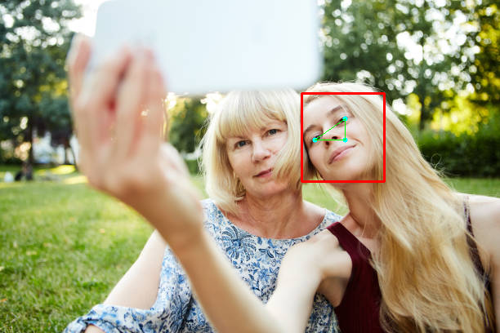

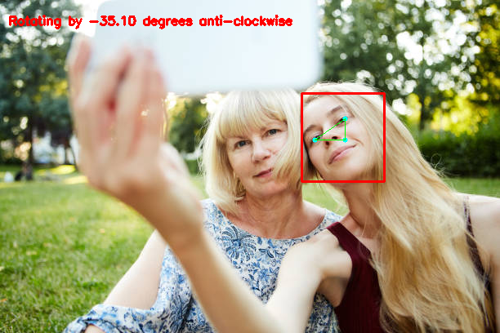

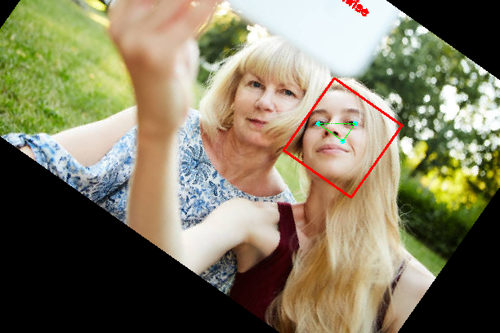

In [45]:
frame_num = 1
def save_image(image, pad_width):
    global frame_num
    display_image = Image.fromarray(image[pad_width:-pad_width, pad_width:-pad_width])
    frame_num += 1
    # display_image.save(f"frames/image_{frame_num}.jpg")
    if frame_num >= 5:
        display(ImageOps.contain(display_image, (500, 500)))
    

!rm -rf frames
if not os.path.exists("frames"):
    os.makedirs("frames")

border_factor = 0.15 # TO ADD: input this as parameter for training

## Loading original image ##
original_img = cv2.imread(image_filepath)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)



## Padding image to ensure during rotation faces do not leave the image ##
pad_width = max(original_img.shape[:2])//2
original_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
original_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()
# save_image(original_img_padded, pad_width, 1)

## finding boxes, landmarks in original image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device) # Face detection model
original_boxes, original_landmarks, original_probs = generate_boxes_landmarks(original_img_padded, mtcnn, device)

### For visualization purposes ###
# Drawing boxes on all faces
annotated_faces_img = original_img_padded.copy()
for box in original_boxes:
    cv2.rectangle(annotated_faces_img, box[:2], box[2:], (255, 0, 0), 2)
# save_image(annotated_faces_img, pad_width, 2)

annotated_faces_img = original_img_padded.copy()
for box, landmark in zip(original_boxes, original_landmarks):
    #1. Draw original face box on
    cv2.rectangle(annotated_faces_img, box[:2], box[2:], (255, 0, 0), 2)

    #2. Drawing eyes
    left_eye, right_eye = landmark[0], landmark[1]
    cv2.circle(annotated_faces_img, left_eye, 3, (0,255,255), -1)
    save_image(annotated_faces_img, pad_width)
    cv2.circle(annotated_faces_img, right_eye, 3, (0,255,255), -1)
    save_image(annotated_faces_img, pad_width)

    #3. Creating and drawing 3rd point to create triangle
    if left_eye[1] > right_eye[1]: # right eye higher than left eye
        third_point = (right_eye[0], left_eye[1]) # rotating clockwise
    else:
        third_point = (left_eye[0], right_eye[1]) # rotating counter-clockwise
    cv2.circle(annotated_faces_img, third_point, 3, (0,255,255), -1)
    save_image(annotated_faces_img, pad_width)
    
    #4. Drawing triangle
    for pair in [[left_eye, right_eye], [left_eye, third_point], [right_eye, third_point]]:
        cv2.line(annotated_faces_img, pair[0], pair[1], (0,255,0), 1)
    save_image(annotated_faces_img, pad_width)

    #5. Calculating and writing angle on image
    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    cv2.putText(annotated_faces_img, f"Rotating by {rotate_angle:.2f} degrees anti-clockwise", (pad_width+10,pad_width+30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    save_image(annotated_faces_img, pad_width)

    #6. rotate and display Image
    annotated_faces_img = np.array(Image.fromarray(annotated_faces_img).rotate(rotate_angle, center=face_centre, expand=False))
    save_image(annotated_faces_img, pad_width)
    break



In [ ]:
#3. Perform Facial obfuscation 
for box in original_boxes:
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    width_border = int(width * border_factor)
    height_border = int(height * border_factor)
    cv2.rectangle(annotated_faces_img, [x1+width_border, y1+height_border], [x2-width_border, y2-height_border], (255, 255, 255), -1)
save_image(annotated_faces_img, pad_width, 1)

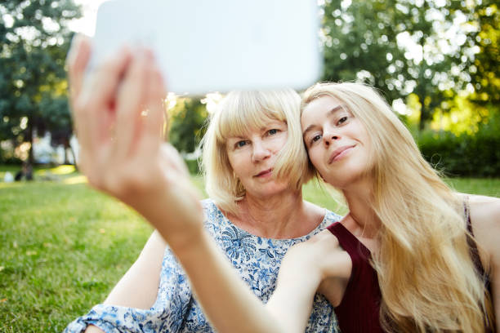

rotate angle: -35.10 degrees
width: 607, height: 805
Losses, 0 iteration:: Complete:-3.3565, contextual:0.1433, perceptual:-3.4998 (after x0.1), time: 0.08s
Losses, 300 iteration:: Complete:-6.7005, contextual:0.2086, perceptual:-6.9091 (after x0.1), time: 20.67s
Losses, 600 iteration:: Complete:-6.9925, contextual:0.2122, perceptual:-7.2047 (after x0.1), time: 41.68s
Losses, 900 iteration:: Complete:-7.1106, contextual:0.2120, perceptual:-7.3226 (after x0.1), time: 62.56s
Losses, 1200 iteration:: Complete:-7.0468, contextual:0.2115, perceptual:-7.2584 (after x0.1), time: 82.98s
Losses, 1499 iteration:: Complete:-7.2043, contextual:0.2117, perceptual:-7.4160 (after x0.1), time: 103.90s


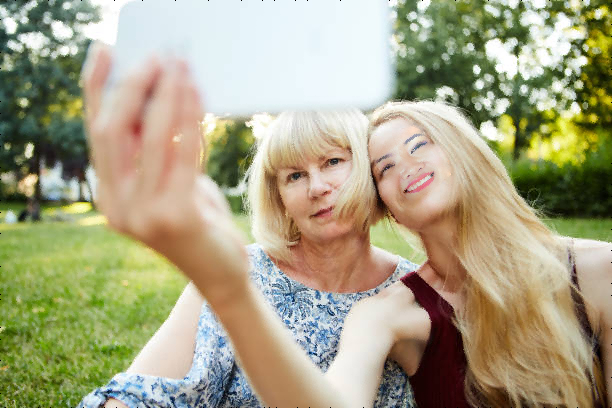

rotate angle: -20.73 degrees
width: 625, height: 829
Losses, 0 iteration:: Complete:-1.5322, contextual:0.1745, perceptual:-1.7066 (after x0.1), time: 0.07s
Losses, 300 iteration:: Complete:-3.9435, contextual:0.2001, perceptual:-4.1436 (after x0.1), time: 21.73s
Losses, 600 iteration:: Complete:-4.5589, contextual:0.2048, perceptual:-4.7636 (after x0.1), time: 42.93s
Losses, 900 iteration:: Complete:-4.9655, contextual:0.1990, perceptual:-5.1645 (after x0.1), time: 63.38s
Losses, 1200 iteration:: Complete:-4.7991, contextual:0.1951, perceptual:-4.9942 (after x0.1), time: 84.45s
Losses, 1499 iteration:: Complete:-4.6197, contextual:0.1955, perceptual:-4.8152 (after x0.1), time: 105.49s


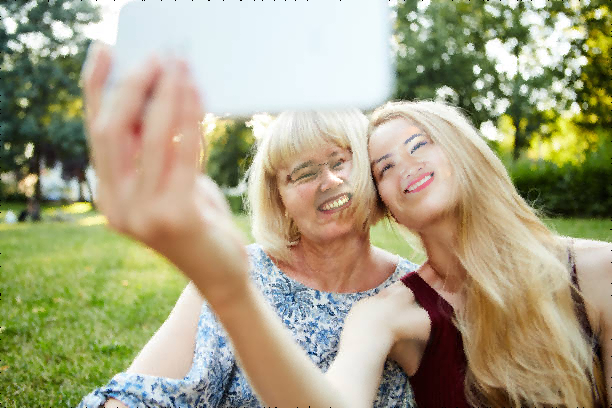

In [ ]:
## Looping through each face in the image ##
for box, landmark in zip(original_boxes, original_landmarks):
    left_eye, right_eye = landmark[0], landmark[1]
    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    print(f"rotate angle: {rotate_angle:.2f} degrees")

    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    face_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
    rotated_img = np.array(Image.fromarray(original_img_padded).rotate(rotate_angle, center=face_centre, expand=False))
    rotated_box = find_new_bbox_cords(mtcnn, rotated_img, face_centre, device)
    cropped_face = rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]].copy()
    
    break
    #Inpaint face
    fixed_noise = torch.randn([1, G.z_dim]).to(device) # 512 latent vector     
    inpainted_faces = inpaint(G, D, mtcnn, device, cropped_face, fixed_noise, lr = 0.003, iterations = 1500, lam = 1, eval_interval = 300)

    inpainted_face = inpainted_faces[-1]
    #Poisson blend inpainted face onto rotated face
    # rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]] = inpainted_face.copy() # naive replacement
    blended_img = poisson_blend(inpainted_face.copy(), rotated_img, rotated_box)

    #rotate back to original orientation and set as base image
    unrotated_img = np.array(Image.fromarray(blended_img).rotate(-rotate_angle, center=face_centre, expand=False))
    original_img_padded = unrotated_img
    # new_img.save(f"frames/image_{i}.jpg")

    display(Image.fromarray(original_img_padded[pad_width:-pad_width, pad_width:-pad_width]))

In [ ]:
!cd frames && ffmpeg -start_number 0 -framerate 5 -i image_%d.jpg \
  -c:v libx264 -pix_fmt yuv420p de-identification-progress.mp4
!mv frames/de-identification-progress.mp4 de-identification-progress.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e